In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import datetime
import math
import numpy as np
import statsmodels.api as sm

# Data Exploration

In [2]:
# load and preview data
xl = pd.ExcelFile('data.xlsx')

data = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

print('Extracting data of W1 sheet:\n')
print(data['W1'].head())

Extracting data of W1 sheet:

   HOURS  MON  TUE  WED  THU  FRI  SAT  SUN
0      0   65   64   91   82  140  112  146
1      1   47   43   49   59   56   63   60
2      2   23   48   32   27   39   77   39
3      3   17   32   13   41   31   45   36
4      4    9    7   22    4   14   45   24


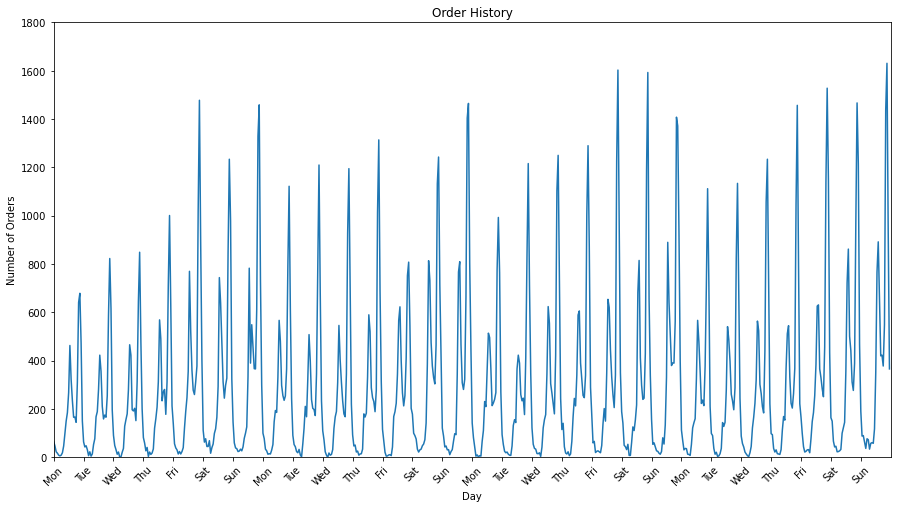

In [3]:
# plot full time series
res = []

for name in xl.sheet_names:
    mylist = map(list, zip(*data[name].values))
    aux = list(it.chain(*mylist))
    del aux[:24]
    res.append(aux)

res = list(it.chain(*res))

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
days_repeated = days * 4

plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(res)
plt.axis([0, 672, 0, 1800])
plt.xticks(range(0,672,24), days_repeated, rotation=45)
plt.xlabel('Day')
plt.ylabel('Number of Orders')
plt.title('Order History')
plt.show()


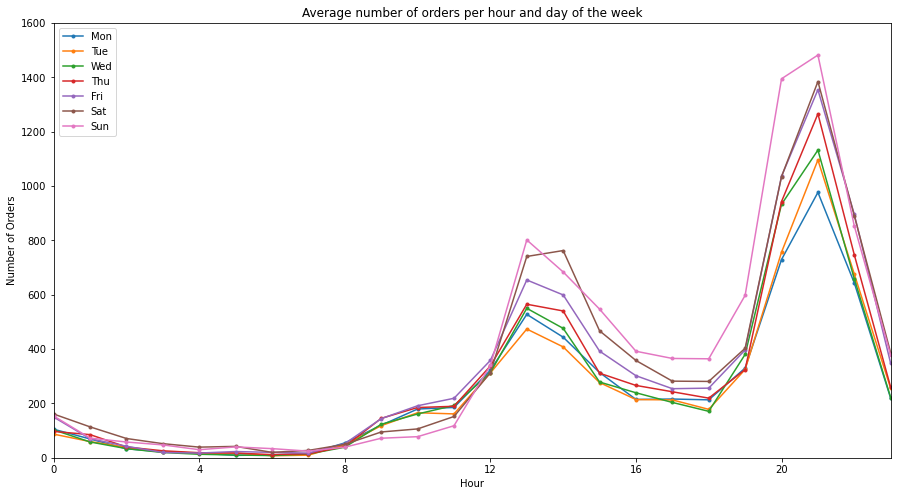

In [4]:
# average orders by hour and day
plt.rcParams['figure.figsize'] = [15, 8]

temp = data['W1'].add(data['W2']).add(data['W3']).add(data['W4'])/4

temp = temp.drop('HOURS', 1)
plt.plot(temp, linestyle='-', marker='.')
plt.axis([0, 23, 0, 1600])
plt.xticks(range(0, 24, 4))
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.title('Average number of orders per hour and day of the week')
plt.legend(days, loc="upper left", fancybox=True)
plt.show()

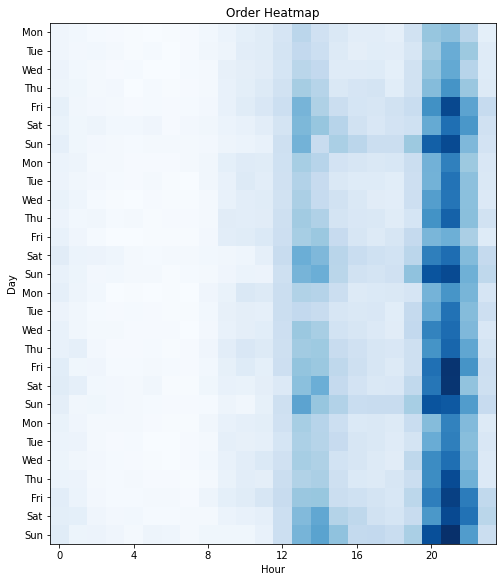

In [5]:
# construct and plot heatmap
plt.rcParams['figure.figsize'] = [8, 15]

orders = [res[i:i + 24] for i in range(0, len(res), 24)]

cols = range(0,24)
rows = range(0,28)
df = pd.DataFrame(orders,
                  columns=cols,
                  index=rows)

ax = plt.imshow(df, interpolation='nearest', cmap='Blues').axes
ax.set_xticks(range(0,24,4))
ax.set_yticks(rows)
ax.set_yticklabels(days_repeated)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Order Heatmap')
ax.grid(False)
plt.show()

# Model Selection

In [6]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

res = []

for name in xl.sheet_names:
    mylist = map(list, zip(*data[name].values))
    aux = list(it.chain(*mylist))
    del aux[:24]
    res.append(aux)

res = list(it.chain(*res))

days = [days for i in range(0, 4)]
days_repeated = days * 4

In [7]:
# Tune Seasonal ARIMA model
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(it.product(p, d, q))
print(pdq)

# Generate all different combinations of seasonal p, q and q triplets
# Seasonality is one week (24*7 = 168 hours)
seasonal_pdq = [(x[0], x[1], x[2], 168) for x in list(it.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 168)
SARIMAX: (0, 0, 1) x (0, 1, 0, 168)
SARIMAX: (0, 1, 0) x (0, 1, 1, 168)
SARIMAX: (0, 1, 0) x (1, 0, 0, 168)


In [8]:
result_list = []
i=0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(res,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if(i>2):        # comment these lines to train full model
                break
            i+=1
            print('ARIMA{}x{}168 - AIC:{}'.format(param, param_seasonal, round(results.aic,2)))
            result_list.extend([param, param_seasonal, round(results.aic,2)])
        except:
            print('error')
            continue
            
print('Done!')

ARIMA(0, 0, 0)x(0, 0, 0, 168)168 - AIC:10097.43


C:\Users\Abhinav\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(0, 0, 1, 168)168 - AIC:19202.44
ARIMA(0, 0, 0)x(0, 1, 0, 168)168 - AIC:6053.09


C:\Users\Abhinav\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Done!


In [9]:
print_result = zip(*[iter(result_list)]*3) 
print_result = sorted(print_result,key=lambda x: x[2])

print('Result summary:\n')
print('((p, d, q), (P, D, Q, S), AIC)')
print('------------------------------')
for item in print_result:
    print(item)

Result summary:

((p, d, q), (P, D, Q, S), AIC)
------------------------------
((0, 0, 0), (0, 1, 0, 168), 6053.09)
((0, 0, 0), (0, 0, 0, 168), 10097.43)
((0, 0, 0), (0, 0, 1, 168), 19202.44)


# Forecasting/ Predicting with the help of SARIMA model

In [10]:
# load data
res = []

for name in xl.sheet_names:
    mylist = map(list, zip(*data[name].values))
    aux = list(it.chain(*mylist))
    del aux[:24]
    res.append(aux)

res = list(it.chain(*res))

3818.95
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3928      0.029     13.708      0.000       0.337       0.449
ma.L1         -0.9896      0.017    -58.086      0.000      -1.023      -0.956
ar.S.L168     -0.4395      0.020    -22.298      0.000      -0.478      -0.401
sigma2      5239.9150    184.642     28.379      0.000    4878.024    5601.806


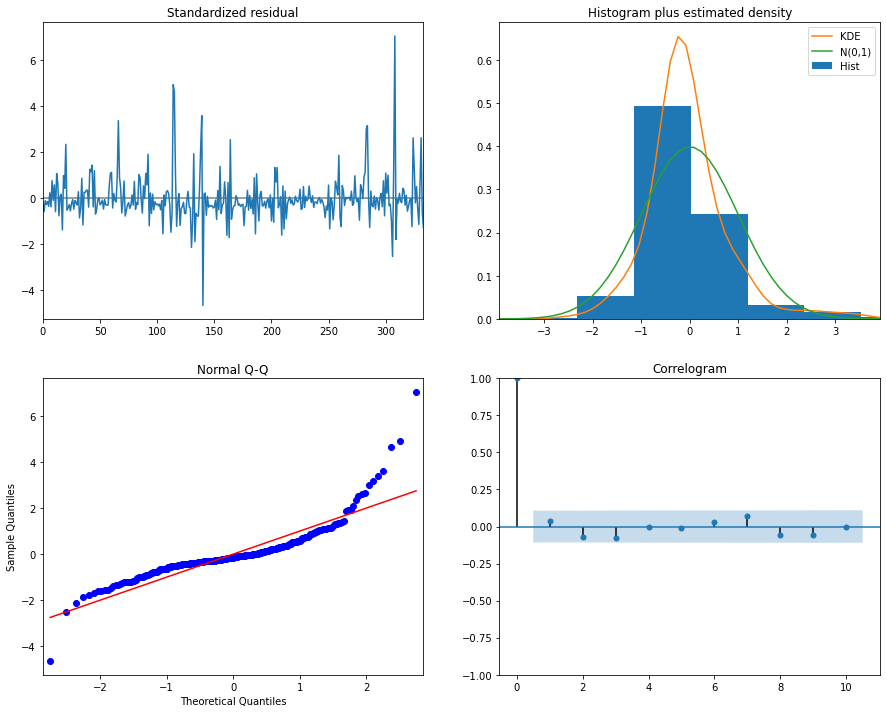

In [11]:
# train Seasonal ARIMA model
mod = sm.tsa.statespace.SARIMAX(res,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 168),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(round(results.aic,2))
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

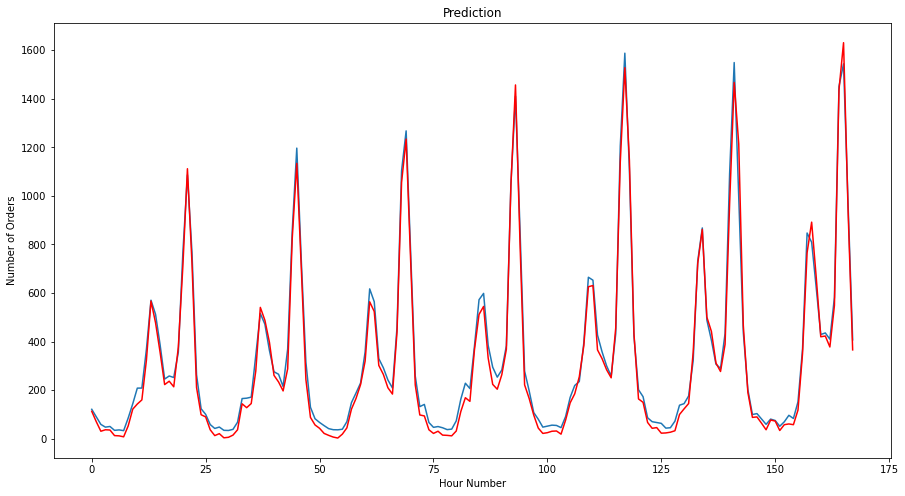

In [12]:
# Get forecast one week ahead in future
pred_uc = results.get_forecast(steps=168)

plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(pred_uc.predicted_mean)
plt.plot(res[-168:], color='red') # compare with previous week
plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Prediction')
plt.show()

In [13]:
# save to excel
rows = range(0,24)
cols = ['HOURS', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

df = pd.DataFrame(columns=cols,
                  index=rows)
df['HOURS'] = rows

pred_uc.predicted_mean = pred_uc.predicted_mean.astype(int)
fc = [pred_uc.predicted_mean[i:i + 24] for i in range(0, len(pred_uc.predicted_mean), 24)]

for i in enumerate(fc):
    df[cols[i[0] + 1]] = i[1]

# df.to_excel('results.xlsx', sheet_name='W5', index=False)

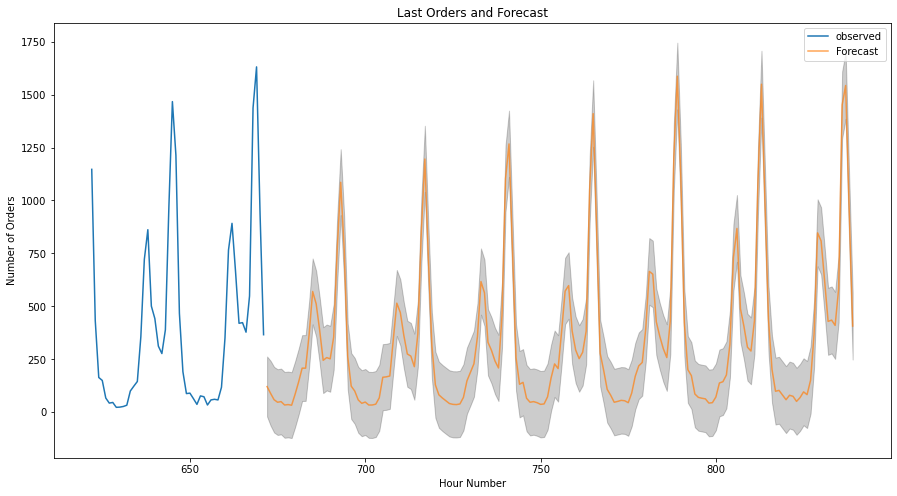

In [14]:
# plot LAST_N_SAMPLES and prediction
LAST_N_SAMPLES = 50

pred_ci = pred_uc.conf_int()

X_obs = range(0, 672)
X_pred = range(672, 840)

plt.plot(X_obs[-LAST_N_SAMPLES:], res[-LAST_N_SAMPLES:], label='observed')
plt.plot(X_pred[:168], pred_uc.predicted_mean[:168], label='Forecast', alpha=.7)

plt.fill_between(X_pred,
                pred_ci[:, 0],
                pred_ci[:, 1], color='k', alpha=.2)

plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Last Orders and Forecast')
plt.legend()
plt.show()

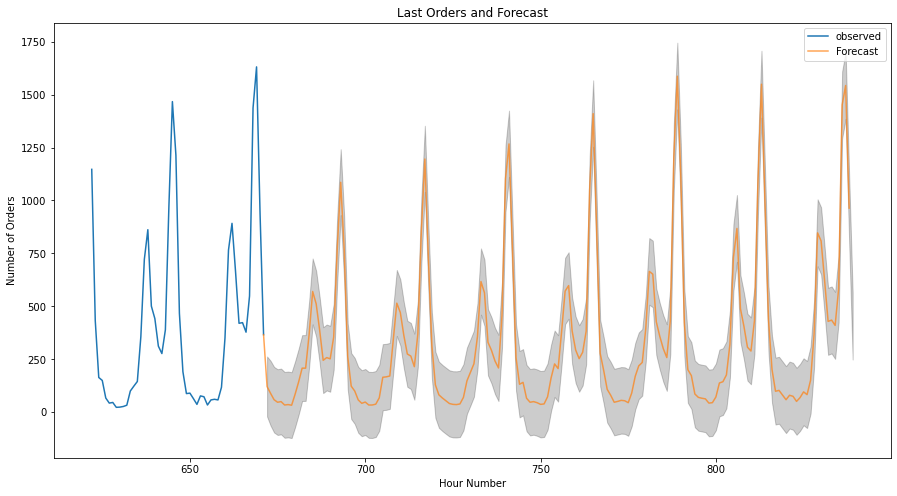

In [15]:
# add last observed value as first predicted one to avoid gap in graph

X_pred = range(671, 840) # predicted range will start one sample before

pred_uc.predicted_mean = np.insert(pred_uc.predicted_mean, 0, res[-1], axis=0) # we insert the value

plt.plot(X_obs[-LAST_N_SAMPLES:], res[-LAST_N_SAMPLES:], label='observed')
plt.plot(X_pred[:168], pred_uc.predicted_mean[:168], label='Forecast', alpha=.7)

plt.fill_between(X_pred[1:], # now we fill confidence interval starting at sample index 1
                pred_ci[:, 0],
                pred_ci[:, 1], color='k', alpha=.2)

plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Last Orders and Forecast')
plt.legend()
plt.show()